# Fundamentals of Deep Learning

!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2020.deeplearning/master/init.py
from init import init; init(force_download=False)

### Recurrent Neural Networks

#### Julián D. Arias Londoño and Raúl Ramos Pollán 

Dept. of Systems Engineering and Computer Science  
Universidad de Antioquia, Medellín, Colombia  
julian.ariasl@udea.edu.co, raul.ramos@udea.edu.co, 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

In [1]:
%matplotlib inline

Recurrent Neural Networks (RNN) are a family of neural networks designed to process sequential data. This type of networks are specially suitable for problems where every sample is a sequence of objects (values) with statistical dependence among them.

![alt text](./local/imgs/RNN2.png "Neuronas")

RNNs can be designed to solve different learning paradigms, in other words, they are able to adapt to different data configurations.

![alt text](./local/imgs/RNN-Topol.jpeg "Neuronas")

Image taken from <a href="http://karpathy.github.io/2015/05/21/rnn-effectiveness/">Andrej Karpathy</a>

Examples:

- 1. Conventional MLP
- 2. Caption generation
- 3. Sentiment analysis
- 4. Language translation
- 5. Time series prediction


### Lets do some examples using conventional MLPs

First we need some data:

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, RepeatVector, TimeDistributed, LSTM
from tensorflow import keras
from local.lib import DataPreparationRNN 

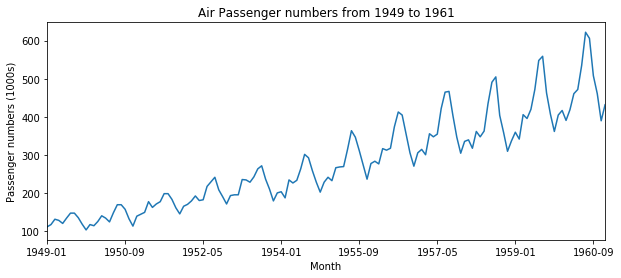

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
datasetO = pd.read_csv('local/data/international-airline-passengers.csv', usecols=[0,1], engine='python', skipfooter=3)
datasetO.plot(0,1,figsize=(10,4))
plt.ylabel('Passenger numbers (1000s)')
plt.title('Air Passenger numbers from 1949 to 1961')
plt.legend().remove()
plt.show()

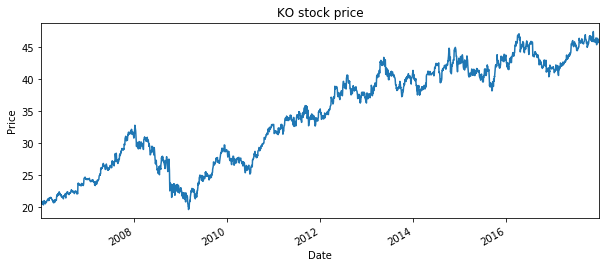

In [30]:
dataset1 = pd.read_csv('local/data/KO_2006-01-01_to_2018-01-01.csv', usecols=['Date','High'], parse_dates=['Date'])
dataset1.plot('Date','High',figsize=(10,4))
plt.ylabel('Price')
plt.title('KO stock price')
plt.legend().remove()
plt.show()

### How to split data for validation purposes?

Traditional approach:

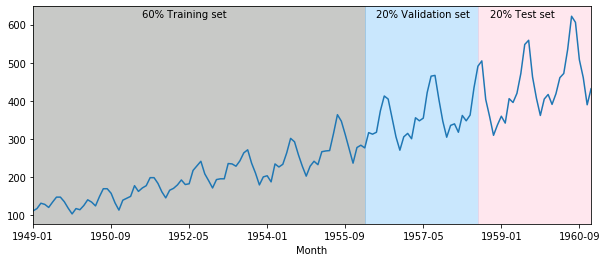

In [5]:
from local.lib import DataPreparationRNN 
datasetO = pd.read_csv('local/data/international-airline-passengers.csv', usecols=[0,1], engine='python', skipfooter=3)
DataPreparationRNN.PlotValidationTimeSeries(datasetO)

Crossvalidation in timeseries:

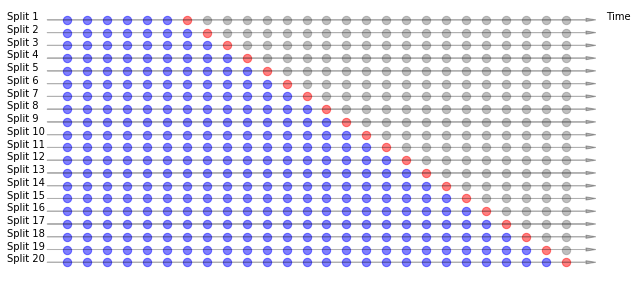

In [6]:
DataPreparationRNN.PlotCrossvalidationTS()

Including a gap between training and validation sets:

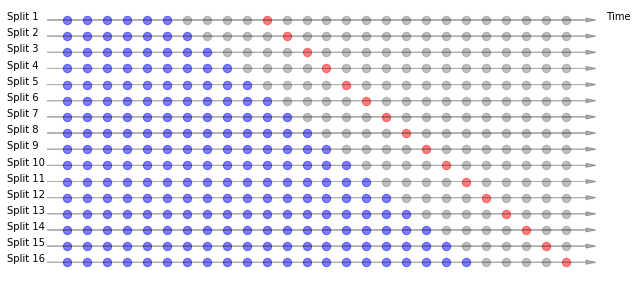

In [7]:
DataPreparationRNN.PlotCrossvalidationTS_Gap()

This can be done using the class TimeSeriesSplit:

In [8]:
from sklearn.model_selection import TimeSeriesSplit
X = np.arange(20)
tscv = TimeSeriesSplit()
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [0 1 2 3 4] TEST: [5 6 7]
TRAIN: [0 1 2 3 4 5 6 7] TEST: [ 8  9 10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10] TEST: [11 12 13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [14 15 16]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] TEST: [17 18 19]


Limiting the number of lacks

In [9]:
X = np.arange(20)
tscv = TimeSeriesSplit(max_train_size=5)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [0 1 2 3 4] TEST: [5 6 7]
TRAIN: [3 4 5 6 7] TEST: [ 8  9 10]
TRAIN: [ 6  7  8  9 10] TEST: [11 12 13]
TRAIN: [ 9 10 11 12 13] TEST: [14 15 16]
TRAIN: [12 13 14 15 16] TEST: [17 18 19]


For simplicity we are goin to split the data manualy into training and validation sets using the classical approach 

In [10]:
from local.lib.DataPreparationRNN import split_sequence
from sklearn.preprocessing import MinMaxScaler
look_back=1
datasetO = pd.read_csv('local/data/international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = datasetO.values
dataset = dataset.astype('float32')
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
trainN = scaler.fit_transform(train)
testN = scaler.transform(test)
X_train, y_train = split_sequence(trainN, look_back)
X_test, y_test = split_sequence(testN, look_back)
print('Train',X_train[:10])
print('Test',y_train[:10])

Train [[[0.02588999]]

 [[0.04530746]]

 [[0.09061491]]

 [[0.08090615]]

 [[0.05501619]]

 [[0.10032365]]

 [[0.14239484]]

 [[0.14239484]]

 [[0.10355988]]

 [[0.04854369]]]
Test [[0.04530746]
 [0.09061491]
 [0.08090615]
 [0.05501619]
 [0.10032365]
 [0.14239484]
 [0.14239484]
 [0.10355988]
 [0.04854369]
 [0.        ]]


Let's create the MLP.

In [11]:
#keras.backend.clear_session()
model1 = Sequential()
model1.add(Dense(5,activation = 'relu',input_dim=look_back))
model1.add(Dense(1))
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 10        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


Train Score: 22.91 RMSE
Test Score: 48.19 RMSE
Train Score: 8.45 MAPE
Test Score: 8.45 MAPE


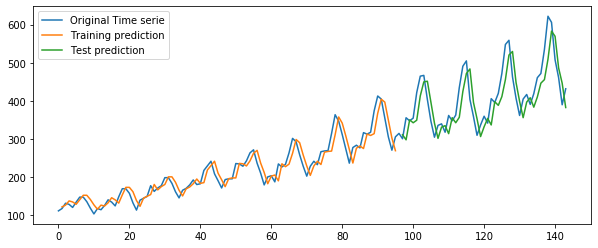

In [13]:
model1.compile(optimizer='adam',loss='mse')
model1.fit(X_train.reshape(X_train.shape[0],look_back),y_train.flatten(),epochs=200, verbose=0)
trainPredict, testPredict = DataPreparationRNN.EstimaRMSE(model1,X_train,X_test,y_train,y_test,scaler,look_back)
DataPreparationRNN.PintaResultado(dataset,trainPredict,testPredict,look_back)

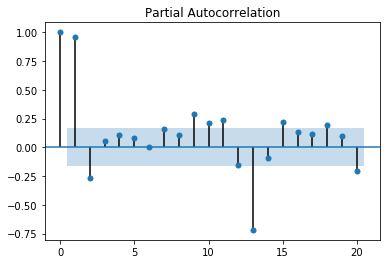

In [30]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(datasetO, lags=20)
plt.show()

Train Score: 0.41 RMSE
Test Score: 0.39 RMSE
Train Score: 0.92 MAPE
Test Score: 0.92 MAPE


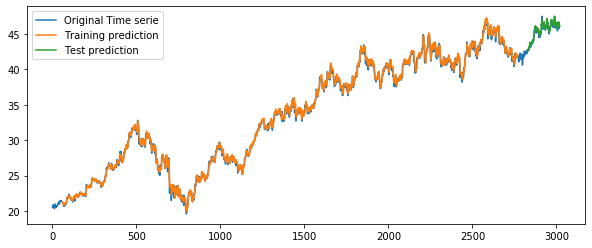

In [45]:
look_back=60
dataset1 = pd.read_csv('local/data/KO_2006-01-01_to_2018-01-01.csv', usecols=['High'])
dataset1[np.isnan(dataset1)] = dataset1['High'].max()
dataset = dataset1.values
dataset = dataset.astype('float32')
# split into train and test sets
test_size = 250
train_size = int(len(dataset) - test_size)
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
trainN = scaler.fit_transform(train)
testN = scaler.transform(test)
X_train, y_train = split_sequence(trainN, look_back)
X_test, y_test = split_sequence(testN, look_back)
#------------------------------------------------------------------
keras.backend.clear_session()
model1 = Sequential()
model1.add(Dense(50,activation = 'relu',input_dim=look_back))
model1.add(Dense(1))
model1.compile(optimizer='adam',loss='mse')
model1.fit(X_train.reshape(X_train.shape[0],look_back),y_train.flatten(),epochs=50, verbose=0)
trainPredict, testPredict = DataPreparationRNN.EstimaRMSE(model1,X_train,X_test,y_train,y_test,scaler,look_back)
DataPreparationRNN.PintaResultado(dataset,trainPredict,testPredict,look_back)

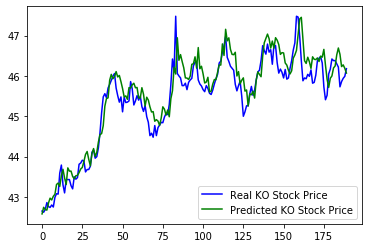

In [50]:
plt.plot(scaler.inverse_transform(y_test),'b',label='Real KO Stock Price')
plt.plot(testPredict,'g',label='Predicted KO Stock Price')
plt.legend()
plt.show()

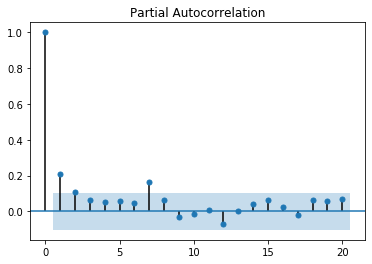

In [41]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(dataset1, lags=20)
plt.show()

There are also problems with basic MLP when we have multiple time series to forecast one of them (**Multiple Input series**), or multiple time series to predict  all of them (**Multiple parallel series**)

### Let's define formaly the Recurrent Neural Networks

An alternative view of the network 

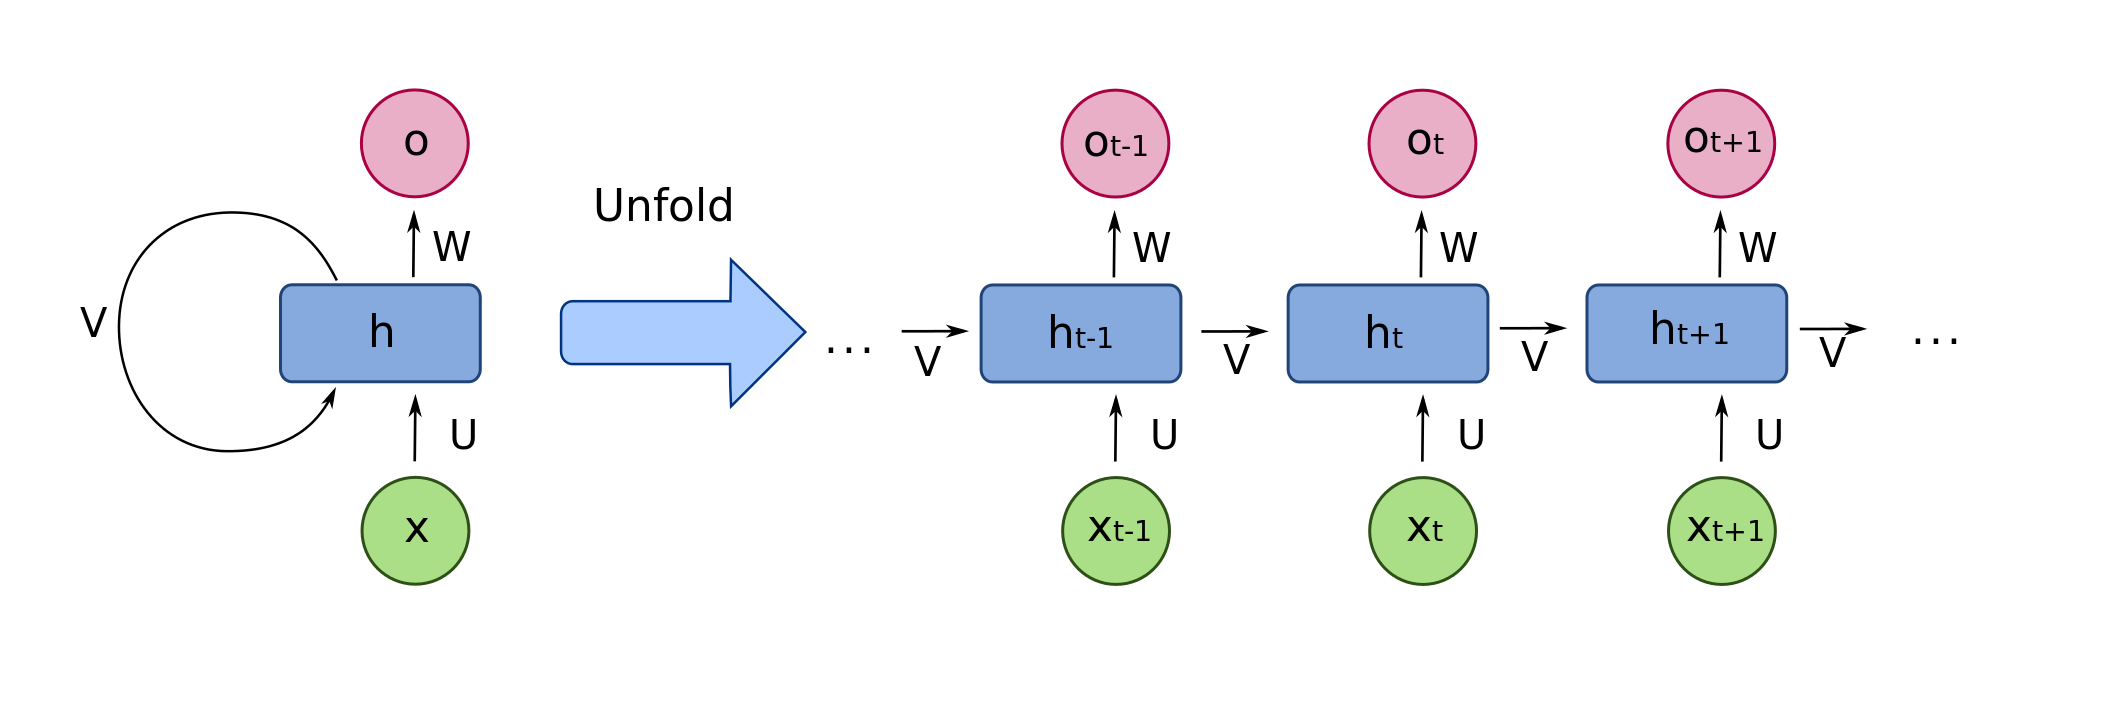

In [19]:
from IPython.display import Image
Image(filename='local/imgs/RNN3.png', width=1200)

According to the notation in the in the former Figure, the mathematical formulation of an Elman RNN with one hidden layer and one output layer is given by:

$${\bf{a}}^{(t)} = {\bf{b}} + {\bf{V}}{\bf{h}}^{(t-1)} + {\bf{U}}{\bf{x}}^{(t)},\\ {\bf{h}}^{(t)} = \tanh({\bf{a}}^{(t)}), \\ {\bf{o}}^{(t)} = {\bf{c}} + {\bf{W}}{\bf{h}}^{(t)}$$

where $\bf{V}$ is the weights matrix of the feedback loop. $\bf{U}$ is the  weights matrix of the inputs and $\bf{W}$ is the weights matrix that contects the **state** of the network with the output layer. $\bf{b}$ and $\bf{c}$ are the bias vectors for the hidden and output layers respectively. The ouput of the network ${\bf{y}}^{(t)}$ corresponds to the application of the activation function to the values ${\bf{o}}^{(t)}$.

### Backpropagation through time (BPTT)

The first step for training a RNN is to define the loss function. Let's consider a sequence of length $\tau$, the loss for that single sequence can be expressed as: 

$$L(\{ {\bf{y}}^{(1)},{\bf{y}}^{(2)},\cdots,{\bf{y}}^{(\tau)} \}, \{ {\bf{\hat{y}}}^{(1)},{\bf{\hat{y}}}^{(2)},\cdots,{\bf{\hat{y}}}^{(\tau)} \}) \\
L = \sum_t L^{(t)}$$

If for instance the loss function for output $i$ is $L^{(t)} = -\log \hat{y}_i^{(t)}$, then

$$(\nabla_{{\bf{o}}^{(t)}}L)_i = \frac{\partial L}{\partial o_i^{(t)}} = \frac{\partial L}{\partial L^{(t)}} \frac{\partial L^{(t)}}{\partial \hat{y}_i^{(t)}} \frac{\partial \hat{y}_i^{(t)}}{\partial o_i^{(t)}} = \hat{y}_i^{(t)} - 1 \\ \nabla_{{\bf{o}}^{(t)}}L = {\bf{y}}^{(t)} \odot ({\bf{\hat{y}}}^{(t)} - {\bf{1}} )$$

where $\odot$ is the Hadamard product. When $t=\tau$, ${\bf{h}}^{(\tau)}$ only has ${\bf{o}}^{(\tau)}$ as descendent, so its gradient is simple:

$$ \nabla_{{\bf{h}}^{(\tau)}} L = {\bf{W}}^T\nabla_{{\bf{o}}^{(\tau)}}L$$

From this two results we can iterate backward in time to back-propagate gradients through time. From $t=\tau-1$ down to $\tau = 1$, ${\bf{h}}^{(t)}$ has two descendents: ${\bf{h}}^{(t+1)}$ and ${\bf{o}}^{(t)}$, therefore its gradient is given by:   

$$ \nabla_{{\bf{h}}^{(t)}}L = \left( \frac{\partial {\bf{h}}^{(t+1)}}{\partial {\bf{h}}^{(t)}}\right)^T(\nabla_{{\bf{h}}^{(t+1)}} L) + \left(\frac{\partial {\bf{o}}^{(t)}}{\partial {\bf{h}}^{(t)}}\right)^T(\nabla_{{\bf{o}}^{(t)}}L) \\
\nabla_{{\bf{h}}^{(t)}}L = {\bf{V}}^T\text{diag} \left( 1 - \left( {\bf{h}}^{(t+1)} \right)^2\right)(\nabla_{{\bf{h}}^{(t+1)}} L) + {\bf{W}}^T(\nabla_{{\bf{o}}^{(t)}}L)$$

Based on the former results, the rest of the gradients can be calculated as:

$$ \nabla_{\bf{c}} L = \sum_t \left(\frac{\partial {\bf{o}}^{(t)}}{\partial {\bf{c}}}\right)^T \nabla_{{\bf{o}}^{(t)}}L$$

$$ \nabla_{\bf{b}} L = \sum_t \left(\frac{\partial {\bf{h}}^{(t)}}{\partial {\bf{b}}}\right)^T \nabla_{{\bf{h}}^{(t)}}L = \sum_t \text{diag}\left( 1 - \left( {\bf{h}}^{(t)} \right)^2\right)\nabla_{{\bf{h}}^{(t)}} L $$

$$\nabla_{{\bf W}}L = \sum_t \sum_i \left(  \frac{\partial L}{\partial o_i^{(t)}} \right)^T \nabla_{{\bf W}} o_i^{(t)} = \sum_t (\nabla_{{\bf{o}}^{(t)}}L){\bf{h}}^{(t)^T}$$

$$\nabla_{\bf V}L = \sum_t \text{diag}\left( 1 - \left( {\bf{h}}^{(t)} \right)^2\right)(\nabla_{{\bf{h}}^{(t)}} L){\bf{h}}^{(t-1)^T}$$

$$ \nabla_{\bf U}L = \sum_t \text{diag}\left( 1 - \left( {\bf{h}}^{(t)} \right)^2\right)(\nabla_{{\bf{h}}^{(t)}} L){\bf{x}}^{(t)^T} $$

## Now using a RNN layer instead of a Dense layer:

Input data must have the following structure: **[n_samples,n_times,n_features]**

Input: **[n_samples,1,1]**

Train Score: 22.91 RMSE
Test Score: 48.70 RMSE
Train Score: 8.52 MAPE
Test Score: 8.52 MAPE


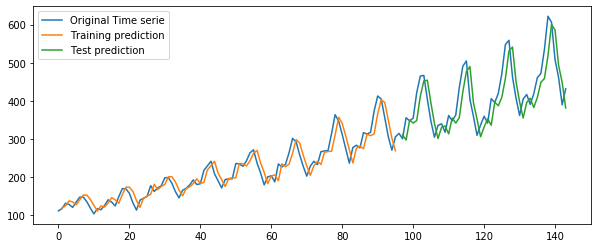

In [16]:
look_back = 1;
dataset = datasetO.values
dataset = dataset.astype('float32')
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
trainN = scaler.fit_transform(train)
testN = scaler.transform(test)
X_train, y_train = DataPreparationRNN.create_dataset(trainN, look_back)
X_test, y_test = DataPreparationRNN.create_dataset(testN, look_back)
model4 = Sequential()
model4.add(SimpleRNN(5,activation = 'relu',input_shape=(1,look_back)))
model4.add(Dense(1))
model4.compile(optimizer='adam',loss='mse')
model4.fit(X_train.reshape(X_train.shape[0],1,look_back),y_train.flatten(),epochs=500, verbose=0)
trainPredict, testPredict = DataPreparationRNN.EstimaRMSE_RNN(model4,X_train,X_test,y_train,y_test,scaler,look_back,1)
DataPreparationRNN.PintaResultado(dataset,trainPredict,testPredict,look_back)

In [17]:
model4.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 5)                 35        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


### Using multiple times as features

Input: **[n_samples,1,2]**

Train Score: 22.22 RMSE
Test Score: 51.10 RMSE
Train Score: 8.43 MAPE
Test Score: 8.43 MAPE


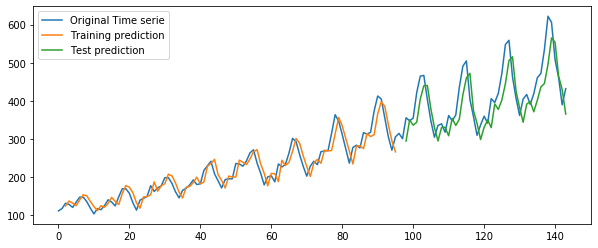

In [18]:
look_back = 2;
X_train, y_train = DataPreparationRNN.create_dataset(trainN, look_back)
X_test, y_test = DataPreparationRNN.create_dataset(testN, look_back)
model4b = Sequential()
model4b.add(SimpleRNN(5,activation = 'relu',input_shape=(1,look_back)))
model4b.add(Dense(1))
model4b.compile(optimizer='adam',loss='mse')
model4b.fit(X_train.reshape(X_train.shape[0],1,look_back),y_train.flatten(),epochs=500, verbose=0)
trainPredict, testPredict = DataPreparationRNN.EstimaRMSE_RNN(model4b,X_train,X_test,y_train,y_test,scaler,look_back,1)
DataPreparationRNN.PintaResultado(dataset,trainPredict,testPredict,look_back)

In [30]:
model4b.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, 5)                 40        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 6         
Total params: 46
Trainable params: 46
Non-trainable params: 0
_________________________________________________________________


Using multiple times instead of multiple features:

### Using multiple times as multiple times!

Input: **[n_samples,2,1]**

Train Score: 22.74 RMSE
Test Score: 51.25 RMSE


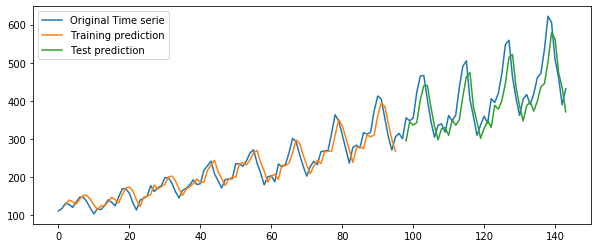

In [35]:
n_steps = 2;
X_train, y_train = DataPreparationRNN.create_dataset(trainN, n_steps)
X_test, y_test = DataPreparationRNN.create_dataset(testN, n_steps)
model6 = Sequential()
model6.add(SimpleRNN(5,activation = 'relu',input_shape=(n_steps,1)))
model6.add(Dense(1))
model6.compile(optimizer='adam',loss='mse')
model6.fit(X_train.reshape(X_train.shape[0],n_steps,1),y_train.flatten(),epochs=500, verbose=0)
trainPredict, testPredict = DataPreparationRNN.EstimaRMSE_RNN(model6,X_train,X_test,y_train,y_test,scaler,1,n_steps)
DataPreparationRNN.PintaResultado(dataset,trainPredict,testPredict,n_steps)

In [32]:
model6.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_7 (SimpleRNN)     (None, 5)                 35        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 6         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


Train Score: 0.31 RMSE
Test Score: 0.29 RMSE
Train Score: 0.68 MAPE
Test Score: 0.68 MAPE


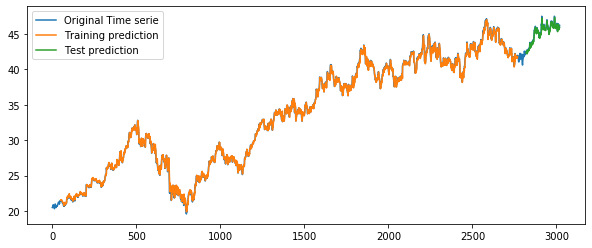

In [71]:
n_steps = 50;
dataset = dataset1.values
dataset = dataset.astype('float32')
# split into train and test sets
test_size = 250
train_size = int(len(dataset) - test_size)
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
trainN = scaler.fit_transform(train)
testN = scaler.transform(test)
X_train, y_train = DataPreparationRNN.create_dataset(trainN, n_steps)
X_test, y_test = DataPreparationRNN.create_dataset(testN, n_steps)
model6 = Sequential()
model6.add(SimpleRNN(60,activation = 'relu',input_shape=(n_steps,1)))
model6.add(Dense(1))
model6.compile(optimizer='adam',loss='mse')
model6.fit(X_train.reshape(X_train.shape[0],n_steps,1),y_train.flatten(),verbose=0,epochs=50,batch_size=32)
trainPredict, testPredict = DataPreparationRNN.EstimaRMSE_RNN(model6,X_train,X_test,y_train,y_test,scaler,1,n_steps)
DataPreparationRNN.PintaResultado(dataset,trainPredict,testPredict,n_steps)

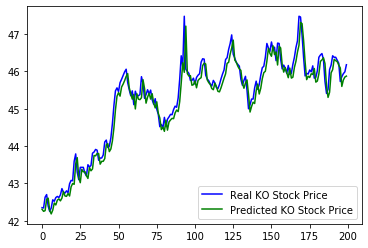

In [72]:
plt.plot(scaler.inverse_transform(y_test[:, np.newaxis]),'b',label='Real KO Stock Price')
plt.plot(testPredict.flatten(),'g',label='Predicted KO Stock Price')
plt.legend()
plt.show()

### Two recurrent layers:

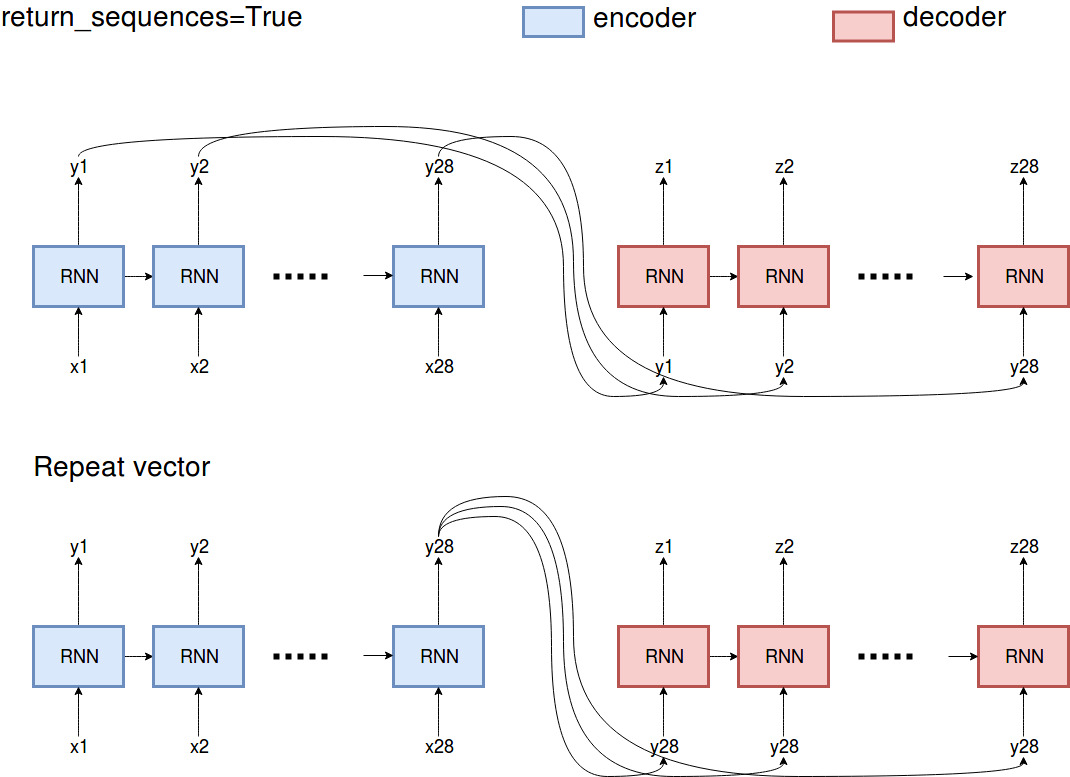

In [38]:
Image(filename='local/imgs/ReturnSeq.jpg', width=800)

Input: **[n_samples,1,1]**

**Option1**: Propagate the first layer and provide only the output of the last time step to the following layer:

Train Score: 21.93 RMSE
Test Score: 48.39 RMSE


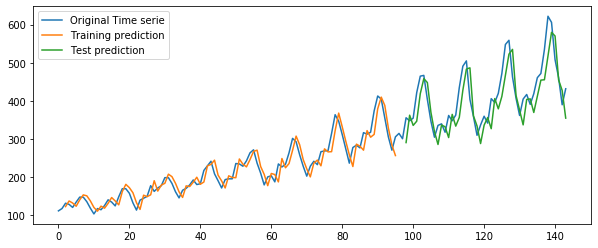

In [54]:
look_back = 2;
dataset = datasetO.values
dataset = dataset.astype('float32')
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
trainN = scaler.fit_transform(train)
testN = scaler.transform(test)
X_train, y_train = DataPreparationRNN.create_dataset(trainN, look_back)
X_test, y_test = DataPreparationRNN.create_dataset(testN, look_back)
model5 = Sequential()
model5.add(SimpleRNN(5,activation = 'relu',input_shape=(1,look_back)))
model5.add(RepeatVector(look_back))
model5.add(SimpleRNN(5,activation = 'relu'))
model5.add(Dense(1))
model5.compile(optimizer='adam',loss='mse')
model5.fit(X_train.reshape(X_train.shape[0],1,look_back),y_train.flatten(),epochs=500, verbose=0)
trainPredict, testPredict = DataPreparationRNN.EstimaRMSE_RNN(model5,X_train,X_test,y_train,y_test,scaler,look_back,1)
DataPreparationRNN.PintaResultado(dataset,trainPredict,testPredict,look_back)

In [55]:
model5.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, 5)                 40        
_________________________________________________________________
repeat_vector (RepeatVector) (None, 2, 5)              0         
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 5)                 55        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 6         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


Train Score: 0.42 RMSE
Test Score: 0.41 RMSE
Train Score: 0.94 MAPE
Test Score: 0.94 MAPE


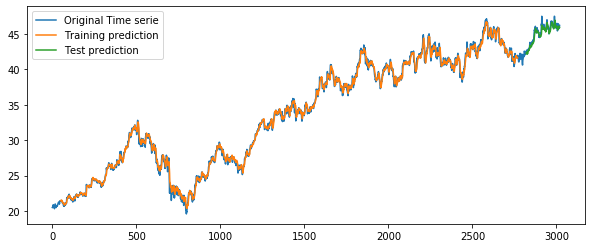

In [73]:
look_back = 50;
dataset = dataset1.values
dataset = dataset.astype('float32')
# split into train and test sets
test_size = 250
train_size = int(len(dataset) - test_size)
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
trainN = scaler.fit_transform(train)
testN = scaler.transform(test)
X_train, y_train = DataPreparationRNN.create_dataset(trainN, look_back)
X_test, y_test = DataPreparationRNN.create_dataset(testN, look_back)
model5 = Sequential()
model5.add(SimpleRNN(60,activation = 'relu',input_shape=(1,look_back)))
model5.add(RepeatVector(look_back))
model5.add(SimpleRNN(60,activation = 'relu',kernel_regularizer=keras.regularizers.l2(0.01)))
model5.add(Dense(1))
model5.compile(optimizer='adam',loss='mse')
model5.fit(X_train.reshape(X_train.shape[0],1,look_back),y_train.flatten(),epochs=50, validation_split=0.10,verbose=0)
trainPredict, testPredict = DataPreparationRNN.EstimaRMSE_RNN(model5,X_train,X_test,y_train,y_test,scaler,look_back,1)
DataPreparationRNN.PintaResultado(dataset,trainPredict,testPredict,look_back)

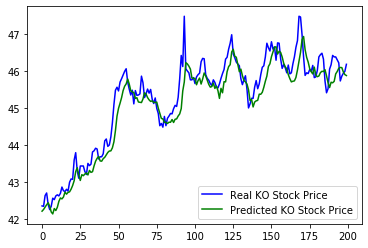

In [74]:
plt.plot(scaler.inverse_transform(y_test[:, np.newaxis]),'b',label='Real KO Stock Price')
plt.plot(testPredict.flatten(),'g',label='Predicted KO Stock Price')
plt.legend()
plt.show()

**Option2**: Propagate the first layer and provide every output of the first layer to the following layer:

Train Score: 22.24 RMSE
Test Score: 46.82 RMSE


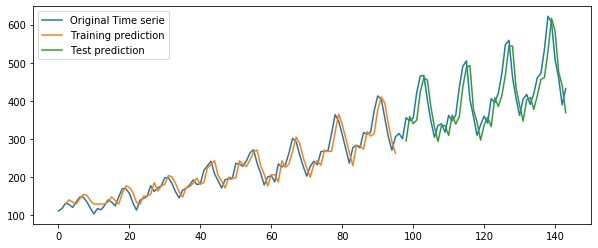

In [66]:
look_back = 2;
dataset = datasetO.values
dataset = dataset.astype('float32')
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
trainN = scaler.fit_transform(train)
testN = scaler.transform(test)
X_train, y_train = DataPreparationRNN.create_dataset(trainN, look_back)
X_test, y_test = DataPreparationRNN.create_dataset(testN, look_back)
model5b = Sequential()
model5b.add(SimpleRNN(5,activation = 'relu',return_sequences=True,input_shape=(1,look_back)))
model5b.add(SimpleRNN(5,activation = 'relu'))
model5b.add(Dense(1))
model5b.compile(optimizer='adam',loss='mse')
model5b.fit(X_train.reshape(X_train.shape[0],1,look_back),y_train.flatten(),epochs=500, verbose=0)
trainPredict, testPredict = DataPreparationRNN.EstimaRMSE_RNN(model5b,X_train,X_test,y_train,y_test,scaler,look_back,1)
DataPreparationRNN.PintaResultado(dataset,trainPredict,testPredict,look_back)

In [67]:
model5b.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_27 (SimpleRNN)    (None, 1, 5)              40        
_________________________________________________________________
simple_rnn_28 (SimpleRNN)    (None, 5)                 55        
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 6         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


Train Score: 0.39 RMSE
Test Score: 0.35 RMSE
Train Score: 0.87 MAPE
Test Score: 0.87 MAPE


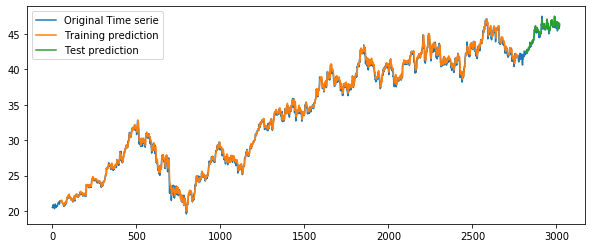

In [75]:
look_back = 50;
dataset = dataset1.values
dataset = dataset.astype('float32')
# split into train and test sets
test_size = 250
train_size = int(len(dataset) - test_size)
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
trainN = scaler.fit_transform(train)
testN = scaler.transform(test)
X_train, y_train = DataPreparationRNN.create_dataset(trainN, look_back)
X_test, y_test = DataPreparationRNN.create_dataset(testN, look_back)
model5b = Sequential()
model5b.add(SimpleRNN(60,activation = 'relu',return_sequences=True,input_shape=(1,look_back)))
model5b.add(SimpleRNN(60,activation = 'relu'))
model5b.add(Dense(1))
model5b.compile(optimizer='adam',loss='mse')
model5b.fit(X_train.reshape(X_train.shape[0],1,look_back),y_train.flatten(),epochs=50, validation_split=0.10, verbose=0)
trainPredict, testPredict = DataPreparationRNN.EstimaRMSE_RNN(model5b,X_train,X_test,y_train,y_test,scaler,look_back,1)
DataPreparationRNN.PintaResultado(dataset,trainPredict,testPredict,look_back)

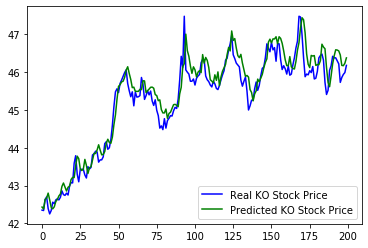

In [76]:
plt.plot(scaler.inverse_transform(y_test[:, np.newaxis]),'b',label='Real KO Stock Price')
plt.plot(testPredict.flatten(),'g',label='Predicted KO Stock Price')
plt.legend()
plt.show()